In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import os
import pickle

warnings.filterwarnings('ignore')

# --- 1. 데이터 로드 ---
print("=== 1단계: 데이터셋 분할 및 Windowing ===")
df = pd.read_csv('cleaned_vitals_for_modeling.csv')
df['charttime'] = pd.to_datetime(df['charttime'])
print(f"로드된 데이터: {len(df):,} 행, {len(df.columns)} 열")
print(f"환자 수: {df['hadm_id'].nunique():,}명")
print(f"측정 항목: {df['itemid'].nunique()}개")

# --- 2. 윈도우 생성을 위한 데이터 준비 ---
# 각 환자별로 시간순으로 정렬
df_sorted = df.sort_values(['hadm_id', 'charttime']).reset_index(drop=True)

# 각 환자별 라벨 확인 (심부전 여부)
# 'heart_failure' -> 'label'로 수정
patient_labels = df_sorted.groupby('hadm_id')['label'].first().reset_index()
print(f"\n라벨 분포:")
# 'heart_failure' -> 'label'로 수정
print(f"  - 심부전 환자: {(patient_labels['label'] == 1).sum()}명")
print(f"  - 정상 환자: {(patient_labels['label'] == 0).sum()}명")

# --- 3. 시계열 윈도우 생성 함수 ---
def create_time_windows(df, window_size=24, step_size=6):
    """
    시계열 데이터를 윈도우로 분할하는 함수
    
    Args:
        df: 정제된 데이터프레임
        window_size: 윈도우 크기 (시간 단위, 기본 24시간)
        step_size: 슬라이딩 윈도우 스텝 (시간 단위, 기본 6시간)
    
    Returns:
        windows: 윈도우별 데이터 리스트
        labels: 각 윈도우의 라벨
        patient_ids: 각 윈도우의 환자 ID
    """
    windows = []
    labels = []
    patient_ids = []
    window_timestamps = []
    
    # 각 환자별로 처리
    for hadm_id in df['hadm_id'].unique():
        patient_data = df[df['hadm_id'] == hadm_id].copy()
        patient_data = patient_data.sort_values('charttime')
        
        # 환자의 라벨 (심부전 여부)
        # 'heart_failure' -> 'label'로 수정
        patient_label = patient_data['label'].iloc[0]
        
        # 시작 시간과 종료 시간
        start_time = patient_data['charttime'].min()
        end_time = patient_data['charttime'].max()
        
        # 윈도우 생성
        current_time = start_time
        while current_time + pd.Timedelta(hours=window_size) <= end_time:
            window_end = current_time + pd.Timedelta(hours=window_size)
            
            # 해당 시간 범위의 데이터 추출
            window_data = patient_data[
                (patient_data['charttime'] >= current_time) & 
                (patient_data['charttime'] < window_end)
            ]
            
            # 윈도우에 충분한 데이터가 있는 경우만 포함
            if len(window_data) >= 5:  # 최소 5개 측정값 필요
                windows.append(window_data)
                labels.append(patient_label)
                patient_ids.append(hadm_id)
                window_timestamps.append((current_time, window_end))
            
            # 다음 윈도우로 이동
            current_time += pd.Timedelta(hours=step_size)
    
    return windows, labels, patient_ids, window_timestamps

# --- 4. 윈도우 생성 실행 ---
print("\n윈도우 생성 중...")
windows, labels, patient_ids, timestamps = create_time_windows(df_sorted, window_size=24, step_size=6)
print(f"생성된 윈도우 수: {len(windows)}")
print(f"윈도우별 라벨 분포:")
print(f"  - 심부전 윈도우: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"  - 정상 윈도우: {len(labels) - sum(labels)} ({(len(labels) - sum(labels))/len(labels)*100:.1f}%)")

# --- 5. 피처 매트릭스 생성 함수 ---
def create_feature_matrix(windows):
    """
    윈도우 데이터를 모델 학습용 피처 매트릭스로 변환
    """
    feature_matrices = []
    feature_names = []
    
    # 모든 itemid 목록 생성
    all_itemids = sorted(df['itemid'].unique())
    
    for i, window in enumerate(windows):
        # 각 itemid별로 시계열 데이터 생성
        window_matrix = []
        
        for itemid in all_itemids:
            itemid_data = window[window['itemid'] == itemid]
            
            if len(itemid_data) > 0:
                # 시간순으로 정렬하고 값 추출
                itemid_data = itemid_data.sort_values('charttime')
                values = itemid_data['valuenum'].values
                
                # 고정 길이로 맞추기 (패딩 또는 샘플링)
                if len(values) > 20:  # 20개로 제한
                    # 균등하게 샘플링
                    indices = np.linspace(0, len(values)-1, 20, dtype=int)
                    values = values[indices]
                elif len(values) < 20:  # 20개 미만이면 마지막 값으로 패딩
                    padding = np.full(20 - len(values), values[-1])
                    values = np.concatenate([values, padding])
            else:
                # 해당 itemid 데이터가 없으면 0으로 채움
                values = np.zeros(20)
            
            window_matrix.append(values)
        
        # (n_features, sequence_length) 형태로 변환
        window_matrix = np.array(window_matrix)  # shape: (n_itemids, 20)
        feature_matrices.append(window_matrix.T)  # shape: (20, n_itemids)로 전치
    
    return np.array(feature_matrices), all_itemids

# --- 6. 피처 매트릭스 생성 ---
print("\n피처 매트릭스 생성 중...")
X, feature_names = create_feature_matrix(windows)
y = np.array(labels)

print(f"피처 매트릭스 형태: {X.shape}")  # (n_samples, sequence_length, n_features)
print(f"라벨 형태: {y.shape}")
print(f"피처 이름 수: {len(feature_names)}")

# --- 7. 데이터셋 분할 ---
print("\n데이터셋 분할 중...")
# 환자 기준으로 분할 (같은 환자의 윈도우가 train/test에 섞이지 않도록)
unique_patients = list(set(patient_ids))
patient_labels_dict = {pid: labels[i] for i, pid in enumerate(patient_ids) if pid not in [p for j, p in enumerate(patient_ids) if j < i]}

# 환자를 train/temp로 분할
train_patients, temp_patients = train_test_split(
    unique_patients, 
    test_size=0.4, 
    random_state=42,
    stratify=[patient_labels_dict[pid] for pid in unique_patients]
)

# temp를 validation/test로 분할
val_patients, test_patients = train_test_split(
    temp_patients, 
    test_size=0.5, 
    random_state=42,
    stratify=[patient_labels_dict[pid] for pid in temp_patients]
)

# 윈도우를 환자 기준으로 분할
train_indices = [i for i, pid in enumerate(patient_ids) if pid in train_patients]
val_indices = [i for i, pid in enumerate(patient_ids) if pid in val_patients]
test_indices = [i for i, pid in enumerate(patient_ids) if pid in test_patients]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

print(f"훈련 세트: {len(X_train)} 윈도우 (심부전: {sum(y_train)}, 정상: {len(y_train)-sum(y_train)})")
print(f"검증 세트: {len(X_val)} 윈도우 (심부전: {sum(y_val)}, 정상: {len(y_val)-sum(y_val)})")
print(f"테스트 세트: {len(X_test)} 윈도우 (심부전: {sum(y_test)}, 정상: {len(y_test)-sum(y_test)})")

# --- 8. 데이터 정규화 ---
print("\n데이터 정규화 중...")
# 각 피처별로 정규화 (3차원 배열 처리)
scalers = {}
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

for feature_idx in range(X_train.shape[2]):  # 각 피처별로
    scaler = StandardScaler()
    
    # 훈련 데이터로 스케일러 학습 (모든 시퀀스 합쳐서)
    train_feature_data = X_train[:, :, feature_idx].reshape(-1, 1)
    scaler.fit(train_feature_data)
    
    # 각 세트에 적용
    X_train_scaled[:, :, feature_idx] = scaler.transform(
        X_train[:, :, feature_idx].reshape(-1, 1)
    ).reshape(X_train[:, :, feature_idx].shape)
    
    X_val_scaled[:, :, feature_idx] = scaler.transform(
        X_val[:, :, feature_idx].reshape(-1, 1)
    ).reshape(X_val[:, :, feature_idx].shape)
    
    X_test_scaled[:, :, feature_idx] = scaler.transform(
        X_test[:, :, feature_idx].reshape(-1, 1)
    ).reshape(X_test[:, :, feature_idx].shape)
    
    scalers[feature_idx] = scaler

print("✅ 1단계 완료: 데이터셋 분할 및 Windowing")
print(f"최종 피처 형태: (samples, sequence_length, features) = {X_train_scaled.shape}")

# --- 9. 결과 저장 ---
output_dir = '1st'
# 폴더가 없으면 생성
os.makedirs(output_dir, exist_ok=True)

# 데이터를 '1st' 폴더 내에 저장
np.save(os.path.join(output_dir, 'X_train.npy'), X_train_scaled)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val_scaled)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test_scaled)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

# 스케일러와 피처 이름도 '1st' 폴더 내에 저장
with open(os.path.join(output_dir, 'feature_scalers.pkl'), 'wb') as f:
    pickle.dump(scalers, f)

with open(os.path.join(output_dir, 'feature_names.pkl'), 'wb') as f:
    pickle.dump(feature_names, f)

print(f"\n데이터가 다음 파일들로 '{output_dir}' 폴더에 저장되었습니다:")
print(f"- {output_dir}/X_train.npy, X_val.npy, X_test.npy")
print(f"- {output_dir}/y_train.npy, y_val.npy, y_test.npy")
print(f"- {output_dir}/feature_scalers.pkl, feature_names.pkl")

=== 1단계: 데이터셋 분할 및 Windowing ===
로드된 데이터: 51,050 행, 8 열
환자 수: 1,176명
측정 항목: 9개

라벨 분포:
  - 심부전 환자: 288명
  - 정상 환자: 888명

윈도우 생성 중...
생성된 윈도우 수: 14359
윈도우별 라벨 분포:
  - 심부전 윈도우: 3583 (25.0%)
  - 정상 윈도우: 10776 (75.0%)

피처 매트릭스 생성 중...
피처 매트릭스 형태: (14359, 20, 9)
라벨 형태: (14359,)
피처 이름 수: 9

데이터셋 분할 중...
훈련 세트: 8311 윈도우 (심부전: 1942, 정상: 6369)
검증 세트: 2551 윈도우 (심부전: 713, 정상: 1838)
테스트 세트: 3497 윈도우 (심부전: 928, 정상: 2569)

데이터 정규화 중...
✅ 1단계 완료: 데이터셋 분할 및 Windowing
최종 피처 형태: (samples, sequence_length, features) = (8311, 20, 9)

데이터가 다음 파일들로 '1st' 폴더에 저장되었습니다:
- 1st/X_train.npy, X_val.npy, X_test.npy
- 1st/y_train.npy, y_val.npy, y_test.npy
- 1st/feature_scalers.pkl, feature_names.pkl


## 피쳐엔지니어링

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=== 2단계: 피처 엔지니어링 및 데이터 검증 ===")

# --- 1. 저장된 데이터 로드 ---
X_train = np.load('1st/X_train.npy')
X_val = np.load('1st/X_val.npy')
X_test = np.load('1st/X_test.npy')
y_train = np.load('1st/y_train.npy')
y_val = np.load('1st/y_val.npy')
y_test = np.load('1st/y_test.npy')

with open('1st/feature_scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

with open('1st/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"로드된 데이터 형태:")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_val: {X_val.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - Feature names: {len(feature_names)}개")

# --- 2. 기본 통계 정보 ---
print(f"\n데이터 분포:")
print(f"  - 훈련 세트: {len(y_train)} 샘플 (심부전: {sum(y_train)}, 정상: {len(y_train)-sum(y_train)})")
print(f"  - 검증 세트: {len(y_val)} 샘플 (심부전: {sum(y_val)}, 정상: {len(y_val)-sum(y_val)})")
print(f"  - 테스트 세트: {len(y_test)} 샘플 (심부전: {sum(y_test)}, 정상: {len(y_test)-sum(y_test)})")

# ItemID별 의미 있는 이름 매핑
itemid_names = {
    225624: 'BUN',
    220615: 'Creatinine',
    220602: 'Chloride',
    227467: 'INR',
    227465: 'PT',
    225677: 'Phosphorous',
    227429: 'SOFA_Score',
    227446: 'BNP',
    227073: 'Anion_Gap'
}

# --- 3. 추가 피처 엔지니어링 함수 ---
def engineer_statistical_features(X):
    """
    시계열 데이터에서 통계적 피처를 추출
    """
    n_samples, seq_len, n_features = X.shape
    statistical_features = []
    
    for i in range(n_samples):
        sample_features = []
        
        for feature_idx in range(n_features):
            time_series = X[i, :, feature_idx]
            
            # 기본 통계량
            mean_val = np.mean(time_series)
            std_val = np.std(time_series)
            min_val = np.min(time_series)
            max_val = np.max(time_series)
            
            # 변화율 관련
            diff = np.diff(time_series)
            trend = np.polyfit(range(len(time_series)), time_series, 1)[0] if len(time_series) > 1 else 0
            volatility = np.std(diff) if len(diff) > 0 else 0
            
            # 최근값과 평균의 차이
            recent_vs_mean = time_series[-1] - mean_val if len(time_series) > 0 else 0
            
            sample_features.extend([
                mean_val, std_val, min_val, max_val,
                trend, volatility, recent_vs_mean
            ])
        
        statistical_features.append(sample_features)
    
    return np.array(statistical_features)

def engineer_domain_specific_features(X):
    """
    의료 도메인 특화 피처 생성
    """
    n_samples, seq_len, n_features = X.shape
    domain_features = []
    
    # ItemID 인덱스 매핑 (feature_names는 ItemID 리스트)
    itemid_to_idx = {itemid: idx for idx, itemid in enumerate(feature_names)}
    
    for i in range(n_samples):
        sample_features = []
        
        try:
            # BUN/Creatinine 비율 (신장 기능 지표)
            if 225624 in itemid_to_idx and 220615 in itemid_to_idx:
                bun_idx = itemid_to_idx[225624]
                creat_idx = itemid_to_idx[220615]
                bun_vals = X[i, :, bun_idx]
                creat_vals = X[i, :, creat_idx]
                
                # 0으로 나누기 방지
                creat_vals_safe = np.where(creat_vals == 0, 1e-6, creat_vals)
                bun_creat_ratio = np.mean(bun_vals / creat_vals_safe)
            else:
                bun_creat_ratio = 0
            
            # BNP 급격한 변화 (심부전 주요 지표)
            if 227446 in itemid_to_idx:
                bnp_idx = itemid_to_idx[227446]
                bnp_vals = X[i, :, bnp_idx]
                bnp_change_rate = np.std(np.diff(bnp_vals)) if len(bnp_vals) > 1 else 0
                bnp_max = np.max(bnp_vals)
            else:
                bnp_change_rate = 0
                bnp_max = 0
            
            # SOFA Score 악화 (중환자 상태 악화)
            if 227429 in itemid_to_idx:
                sofa_idx = itemid_to_idx[227429]
                sofa_vals = X[i, :, sofa_idx]
                sofa_trend = np.polyfit(range(len(sofa_vals)), sofa_vals, 1)[0] if len(sofa_vals) > 1 else 0
                sofa_max = np.max(sofa_vals)
            else:
                sofa_trend = 0
                sofa_max = 0
            
            # 응고 기능 이상 (INR, PT)
            if 227467 in itemid_to_idx and 227465 in itemid_to_idx:
                inr_idx = itemid_to_idx[227467]
                pt_idx = itemid_to_idx[227465]
                inr_vals = X[i, :, inr_idx]
                pt_vals = X[i, :, pt_idx]
                coag_abnormal = (np.mean(inr_vals) > 1.5) or (np.mean(pt_vals) > 15)
            else:
                coag_abnormal = 0
            
            sample_features.extend([
                bun_creat_ratio, bnp_change_rate, bnp_max,
                sofa_trend, sofa_max, float(coag_abnormal)
            ])
            
        except Exception as e:
            # 에러 발생시 기본값으로 채움
            sample_features.extend([0, 0, 0, 0, 0, 0])
        
        domain_features.append(sample_features)
    
    return np.array(domain_features)

# --- 4. 추가 피처 생성 ---
print("\n추가 피처 생성 중...")

# 통계적 피처
stat_features_train = engineer_statistical_features(X_train)
stat_features_val = engineer_statistical_features(X_val)
stat_features_test = engineer_statistical_features(X_test)

print(f"통계적 피처 형태: {stat_features_train.shape}")

# 의료 도메인 특화 피처
domain_features_train = engineer_domain_specific_features(X_train)
domain_features_val = engineer_domain_specific_features(X_val)
domain_features_test = engineer_domain_specific_features(X_test)

print(f"도메인 특화 피처 형태: {domain_features_train.shape}")

# --- 5. 피처 중요도 분석 ---
print("\n피처 중요도 분석 중...")

# 통계적 피처의 중요도
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(stat_features_train, y_train)

# 중요도 점수
feature_scores = selector.scores_
feature_importance = pd.DataFrame({
    'feature_idx': range(len(feature_scores)),
    'importance': feature_scores
}).sort_values('importance', ascending=False)

print("상위 10개 통계적 피처:")
print(feature_importance.head(10))

# --- 6. 클래스 불균형 확인 ---
print(f"\n클래스 불균형 분석:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  클래스 {u}: {c}개 ({c/len(y_train)*100:.1f}%)")

# 클래스 가중치 계산
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"클래스 가중치: {class_weight_dict}")

# --- 7. 데이터 품질 검사 ---
print(f"\n데이터 품질 검사:")
print(f"  - NaN 값:")
print(f"    - 훈련 세트: {np.isnan(X_train).sum()}")
print(f"    - 검증 세트: {np.isnan(X_val).sum()}")
print(f"    - 테스트 세트: {np.isnan(X_test).sum()}")

print(f"  - Infinite 값:")
print(f"    - 훈련 세트: {np.isinf(X_train).sum()}")
print(f"    - 검증 세트: {np.isinf(X_val).sum()}")
print(f"    - 테스트 세트: {np.isinf(X_test).sum()}")

# NaN이나 Inf 값이 있으면 처리
if np.isnan(X_train).sum() > 0 or np.isinf(X_train).sum() > 0:
    print("  - 이상값 처리 중...")
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=1e6, neginf=-1e6)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
    
    stat_features_train = np.nan_to_num(stat_features_train, nan=0.0, posinf=1e6, neginf=-1e6)
    stat_features_val = np.nan_to_num(stat_features_val, nan=0.0, posinf=1e6, neginf=-1e6)
    stat_features_test = np.nan_to_num(stat_features_test, nan=0.0, posinf=1e6, neginf=-1e6)
    
    domain_features_train = np.nan_to_num(domain_features_train, nan=0.0, posinf=1e6, neginf=-1e6)
    domain_features_val = np.nan_to_num(domain_features_val, nan=0.0, posinf=1e6, neginf=-1e6)
    domain_features_test = np.nan_to_num(domain_features_test, nan=0.0, posinf=1e6, neginf=-1e6)

# --- 8. 최종 데이터 저장 ---
output_dir = '1st'
# 폴더가 없으면 생성 (이전 단계에서 이미 생성되었을 수 있지만, 안전을 위해 확인)
os.makedirs(output_dir, exist_ok=True)

print(f"\n최종 데이터 저장 중... (경로: '{output_dir}')")

# 원본 시계열 데이터 (LSTM/GRU용)
np.save(os.path.join(output_dir, 'X_train_final.npy'), X_train)
np.save(os.path.join(output_dir, 'X_val_final.npy'), X_val)
np.save(os.path.join(output_dir, 'X_test_final.npy'), X_test)

# 추가 피처들
np.save(os.path.join(output_dir, 'stat_features_train.npy'), stat_features_train)
np.save(os.path.join(output_dir, 'stat_features_val.npy'), stat_features_val)
np.save(os.path.join(output_dir, 'stat_features_test.npy'), stat_features_test)

np.save(os.path.join(output_dir, 'domain_features_train.npy'), domain_features_train)
np.save(os.path.join(output_dir, 'domain_features_val.npy'), domain_features_val)
np.save(os.path.join(output_dir, 'domain_features_test.npy'), domain_features_test)

# 클래스 가중치 저장
with open(os.path.join(output_dir, 'class_weights.pkl'), 'wb') as f:
    pickle.dump(class_weight_dict, f)

# 피처 중요도 저장
feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)

print("✅ 2단계 완료: 피처 엔지니어링")
print("저장된 파일:")
print(f"- {output_dir}/X_train_final.npy, X_val_final.npy, X_test_final.npy (시계열 데이터)")
print(f"- {output_dir}/stat_features_*.npy (통계적 피처)")
print(f"- {output_dir}/domain_features_*.npy (도메인 특화 피처)")
print(f"- {output_dir}/class_weights.pkl (클래스 가중치)")
print(f"- {output_dir}/feature_importance.csv (피처 중요도)")

# --- 9. 요약 정보 출력 ---
print(f"\n=== 데이터 준비 완료 ===")
print(f"시계열 데이터 형태: {X_train.shape}")
print(f"통계적 피처 형태: {stat_features_train.shape}")  
print(f"도메인 특화 피처 형태: {domain_features_train.shape}")
print(f"클래스 분포: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"다음 단계: 모델 학습 준비 완료!")

=== 2단계: 피처 엔지니어링 및 데이터 검증 ===
로드된 데이터 형태:
  - X_train: (8311, 20, 9)
  - X_val: (2551, 20, 9)
  - X_test: (3497, 20, 9)
  - Feature names: 9개

데이터 분포:
  - 훈련 세트: 8311 샘플 (심부전: 1942, 정상: 6369)
  - 검증 세트: 2551 샘플 (심부전: 713, 정상: 1838)
  - 테스트 세트: 3497 샘플 (심부전: 928, 정상: 2569)

추가 피처 생성 중...
통계적 피처 형태: (8311, 63)
도메인 특화 피처 형태: (8311, 6)

피처 중요도 분석 중...
상위 10개 통계적 피처:
    feature_idx  importance
17           17  347.765834
14           14  335.219654
16           16  308.099825
58           58  252.265692
51           51  249.539728
49           49  247.621889
56           56  247.301310
52           52  237.421213
59           59  232.217577
31           31  204.970972

클래스 불균형 분석:
  클래스 0: 6369개 (76.6%)
  클래스 1: 1942개 (23.4%)
클래스 가중치: {0: 0.6524572146333805, 1: 2.139804325437693}

데이터 품질 검사:
  - NaN 값:
    - 훈련 세트: 0
    - 검증 세트: 0
    - 테스트 세트: 0
  - Infinite 값:
    - 훈련 세트: 0
    - 검증 세트: 0
    - 테스트 세트: 0

최종 데이터 저장 중... (경로: '1st')
✅ 2단계 완료: 피처 엔지니어링
저장된 파일:
- 1st/X_train_final.npy, X

## 모델 학습

In [3]:
!pip install tensorflow==2.15

  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 53.3 MB/s  0:00:06m0:00:0100:01
Using cached grpcio-1.74.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 120.2 MB/s  0:0

=== 3단계: GRU/LSTM 모델 학습 ===
데이터 형태:
  - X_train: (8311, 20, 9)
  - y_train: (8311,)
  - 클래스 가중치: {0: 0.6524572146333805, 1: 2.139804325437693}
입력 형태: (20, 9)

GRU 모델 생성 중...
LSTM 모델 생성 중...

GRU 모델 구조:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 20, 128)           53376     
                                                                 
 dropout_30 (Dropout)        (None, 20, 128)           0         
                                                                 
 batch_normalization_18 (Ba  (None, 20, 128)           512       
 tchNormalization)                                               
                                                                 
 gru_10 (GRU)                (None, 20, 64)            37248     
                                                                 
 dropout_31 (Dropout)        (None, 20, 64)       

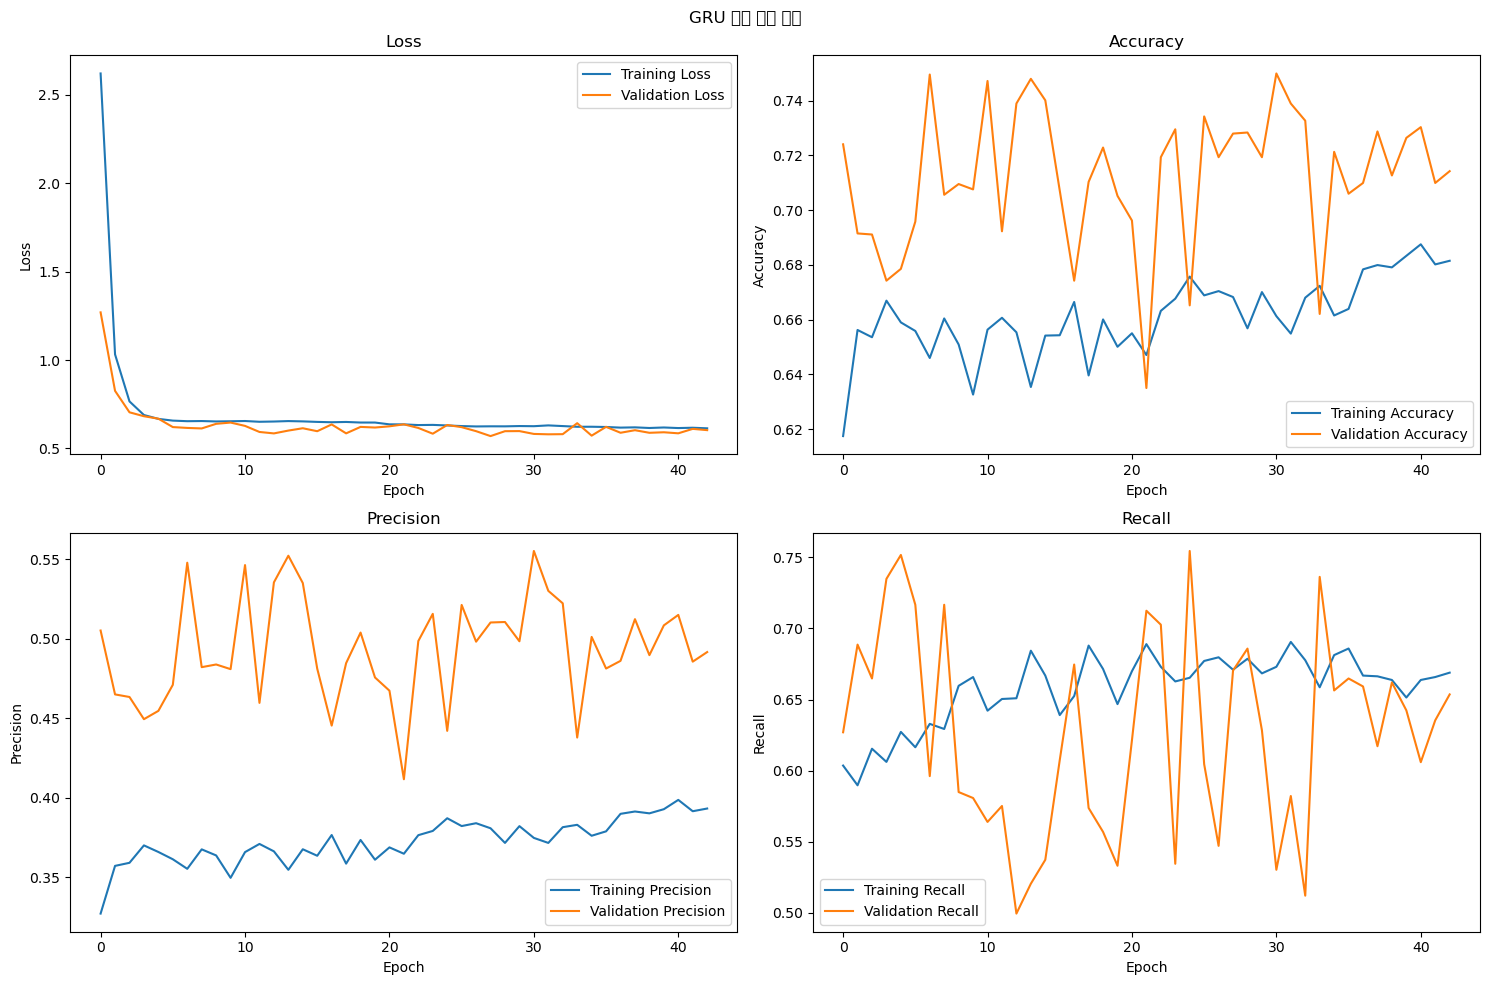

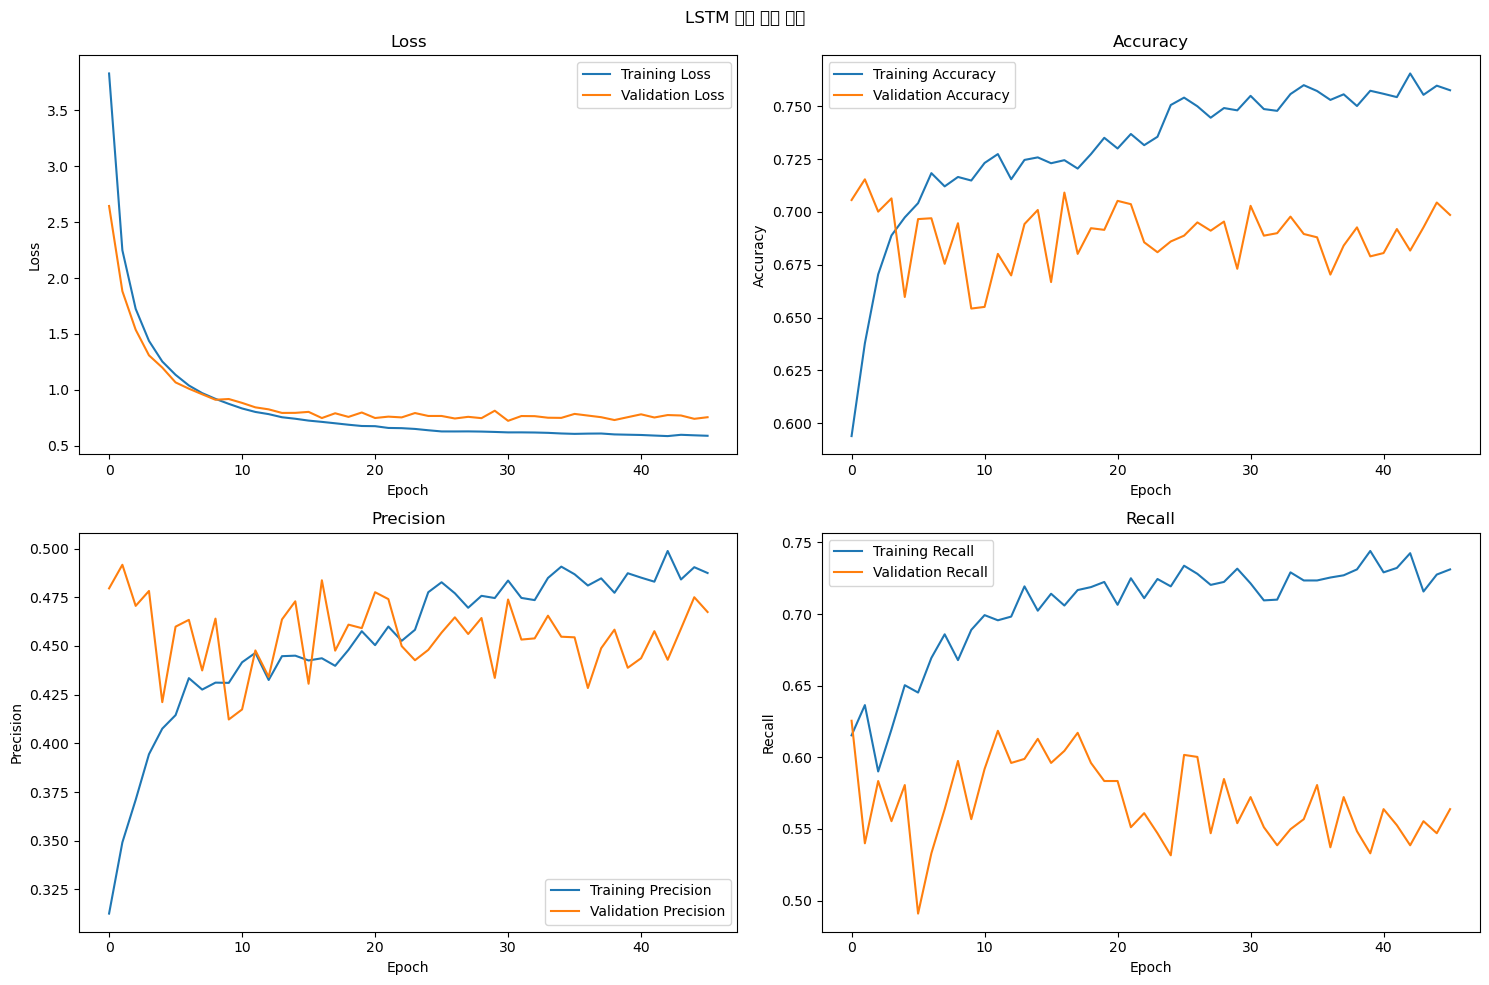


=== GRU 모델 평가 ===
110/110 [==============================] - 1s 5ms/step
테스트 Loss: 0.5823
테스트 Accuracy: 0.6937
테스트 Precision: 0.4427
테스트 Recall: 0.5948
AUC Score: 0.7281
F1 Score: 0.5076

혼동 행렬:
[[1874  695]
 [ 376  552]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2569
           1       0.44      0.59      0.51       928

    accuracy                           0.69      3497
   macro avg       0.64      0.66      0.64      3497
weighted avg       0.73      0.69      0.71      3497


=== LSTM 모델 평가 ===
110/110 [==============================] - 1s 3ms/step
테스트 Loss: 0.7522
테스트 Accuracy: 0.6643
테스트 Precision: 0.3998
테스트 Recall: 0.5291
AUC Score: 0.6769
F1 Score: 0.4555

혼동 행렬:
[[1832  737]
 [ 437  491]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      2569
           1       0.40      0.53      0.46       928

    accuracy                           0.66 

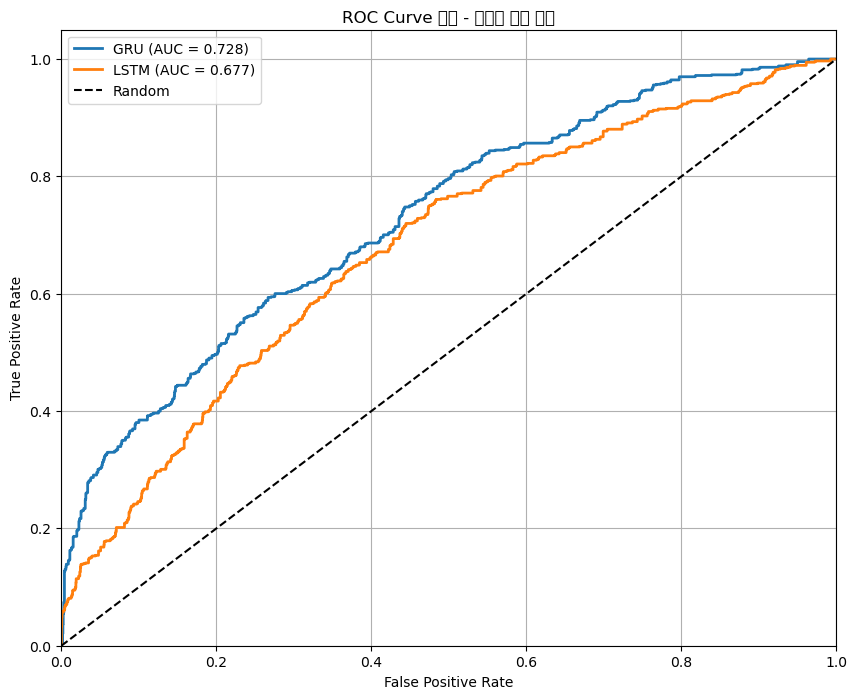


모델 저장 중...
최고 성능 모델: GRU (AUC: 0.7281)
INFO:tensorflow:Assets written to: 1st/heart_failure_model/assets


INFO:tensorflow:Assets written to: 1st/heart_failure_model/assets


모델 메타데이터 저장: 1st/model_metadata.pkl
✅ 3단계 완료: 모델 학습 및 평가

저장된 파일:
- 1st/heart_failure_model.h5 (Keras 모델)
- 1st/heart_failure_model/ (SavedModel)
- 1st/model_metadata.pkl (모델 메타데이터)
- best_gru_model.h5, best_lstm_model.h5 (체크포인트)
- gru_training_history.png, lstm_training_history.png (학습 과정 그래프)
- roc_comparison.png (ROC 곡선)

=== 최종 성능 요약 ===
최고 성능 모델: GRU
AUC Score: 0.7281
정확도: 0.6937
정밀도: 0.4427
재현율: 0.5948
F1 Score: 0.5076


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle
import warnings
import os

warnings.filterwarnings('ignore')

print("=== 3단계: GRU/LSTM 모델 학습 ===")

# --- 1. 데이터 로드 ---
X_train = np.load('1st/X_train_final.npy')
X_val = np.load('1st/X_val_final.npy')
X_test = np.load('1st/X_test_final.npy')
y_train = np.load('1st/y_train.npy')
y_val = np.load('1st/y_val.npy')
y_test = np.load('1st/y_test.npy')

# 추가 피처들 (나중에 앙상블에 사용 가능)
stat_features_train = np.load('1st/stat_features_train.npy')
domain_features_train = np.load('1st/domain_features_train.npy')

with open('1st/class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

print(f"데이터 형태:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - 클래스 가중치: {class_weights}")

# --- 2. 모델 아키텍처 정의 ---
def create_gru_model(input_shape, dropout_rate=0.3, l2_reg=0.01):
    """
    GRU 기반 심부전 예측 모델
    """
    model = models.Sequential([
        # 첫 번째 GRU 레이어 (return_sequences=True로 다음 층에 시퀀스 전달)
        layers.GRU(128, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=regularizers.l2(l2_reg),
                   recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # 두 번째 GRU 레이어
        layers.GRU(64, return_sequences=True,
                   kernel_regularizer=regularizers.l2(l2_reg),
                   recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # 세 번째 GRU 레이어 (마지막 출력만)
        layers.GRU(32, return_sequences=False,
                   kernel_regularizer=regularizers.l2(l2_reg),
                   recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # Dense 레이어들
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate/2),

        # 출력 레이어 (이진 분류)
        layers.Dense(1, activation='sigmoid')
    ])

    return model

def create_lstm_model(input_shape, dropout_rate=0.3, l2_reg=0.01):
    """
    LSTM 기반 심부전 예측 모델
    """
    model = models.Sequential([
        # 첫 번째 LSTM 레이어
        layers.LSTM(128, return_sequences=True, input_shape=input_shape,
                    kernel_regularizer=regularizers.l2(l2_reg),
                    recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # 두 번째 LSTM 레이어
        layers.LSTM(64, return_sequences=True,
                    kernel_regularizer=regularizers.l2(l2_reg),
                    recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # 세 번째 LSTM 레이어
        layers.LSTM(32, return_sequences=False,
                    kernel_regularizer=regularizers.l2(l2_reg),
                    recurrent_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.BatchNormalization(),

        # Dense 레이어들
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate/2),

        # 출력 레이어
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# --- 3. 모델 생성 및 컴파일 ---
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
print(f"입력 형태: {input_shape}")

# GRU 모델 생성
print("\nGRU 모델 생성 중...")
gru_model = create_gru_model(input_shape)

# LSTM 모델 생성
print("LSTM 모델 생성 중...")
lstm_model = create_lstm_model(input_shape)

# 컴파일
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

for model, name in [(gru_model, 'GRU'), (lstm_model, 'LSTM')]:
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    print(f"\n{name} 모델 구조:")
    model.summary()

# --- 4. 콜백 설정 ---
def create_callbacks(model_name):
    return [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            f'best_{model_name.lower()}_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

# --- 5. 모델 학습 ---
print("\n=== 모델 학습 시작 ===")

# GRU 모델 학습
print("\n1. GRU 모델 학습:")
gru_callbacks = create_callbacks('GRU')

gru_history = gru_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=gru_callbacks,
    verbose=1
)

# LSTM 모델 학습
print("\n2. LSTM 모델 학습:")
lstm_callbacks = create_callbacks('LSTM')

lstm_history = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=lstm_callbacks,
    verbose=1
)

# --- 6. 학습 과정 시각화 ---
def plot_training_history(history, model_name):
    """학습 과정 플롯"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} 모델 학습 과정')

    # Loss
    axes[0,0].plot(history.history['loss'], label='Training Loss')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,0].set_title('Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Accuracy
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,1].set_title('Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()

    # Precision
    axes[1,0].plot(history.history['precision'], label='Training Precision')
    axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1,0].set_title('Precision')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()

    # Recall
    axes[1,1].plot(history.history['recall'], label='Training Recall')
    axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1,1].set_title('Recall')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 학습 과정 시각화
plot_training_history(gru_history, 'GRU')
plot_training_history(lstm_history, 'LSTM')

# --- 7. 모델 평가 ---
def evaluate_model(model, model_name, X_test, y_test):
    """모델 성능 평가"""
    print(f"\n=== {model_name} 모델 평가 ===")

    # 예측 수행
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # 성능 지표 계산
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=0)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"테스트 Loss: {test_loss:.4f}")
    print(f"테스트 Accuracy: {test_acc:.4f}")
    print(f"테스트 Precision: {test_prec:.4f}")
    print(f"테스트 Recall: {test_rec:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    # F1 Score 계산
    f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    print(f"\n혼동 행렬:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Classification Report
    print(f"\n분류 보고서:")
    print(classification_report(y_test, y_pred))

    # ROC Curve 데이터 반환
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    return {
        'predictions': y_pred_proba,
        'auc': auc_score,
        'fpr': fpr,
        'tpr': tpr,
        'test_metrics': {
            'loss': test_loss,
            'accuracy': test_acc,
            'precision': test_prec,
            'recall': test_rec,
            'f1': f1,
            'auc': auc_score
        }
    }

# 모델 평가 수행
gru_results = evaluate_model(gru_model, 'GRU', X_test, y_test)
lstm_results = evaluate_model(lstm_model, 'LSTM', X_test, y_test)

# --- 8. ROC Curve 비교 ---
plt.figure(figsize=(10, 8))
plt.plot(gru_results['fpr'], gru_results['tpr'],
         label=f'GRU (AUC = {gru_results["auc"]:.3f})', linewidth=2)
plt.plot(lstm_results['fpr'], lstm_results['tpr'],
         label=f'LSTM (AUC = {lstm_results["auc"]:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve 비교 - 심부전 조기 감지')
plt.legend()
plt.grid(True)
plt.savefig('roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 9. 최종 모델 저장 ---
output_dir = '1st'
# 폴더가 없으면 생성
os.makedirs(output_dir, exist_ok=True)

print("\n모델 저장 중...")

# 최고 성능 모델 선택
best_model_name = 'GRU' if gru_results['auc'] > lstm_results['auc'] else 'LSTM'
best_model = gru_model if best_model_name == 'GRU' else lstm_model
best_results = gru_results if best_model_name == 'GRU' else lstm_results

print(f"최고 성능 모델: {best_model_name} (AUC: {best_results['auc']:.4f})")

# 모델 저장 (여러 형태로 '1st' 폴더에 저장)
best_model.save(os.path.join(output_dir, 'heart_failure_model.h5'))  # Keras 형태
best_model.save(os.path.join(output_dir, 'heart_failure_model'), save_format='tf')  # SavedModel 형태

# 피처 이름 로드 ('1st' 폴더에서 로드)
with open(os.path.join(output_dir, 'feature_names.pkl'), 'rb') as f:
    feature_names = pickle.load(f)

# 모델 메타데이터 저장
model_metadata = {
    'best_model': best_model_name,
    'input_shape': input_shape,
    'feature_names': feature_names,
    'gru_metrics': gru_results['test_metrics'],
    'lstm_metrics': lstm_results['test_metrics'],
    'class_weights': class_weights,
    'itemid_names': {
        225624: 'BUN',
        220615: 'Creatinine',
        220602: 'Chloride',
        227467: 'INR',
        227465: 'PT',
        225677: 'Phosphorous',
        227429: 'SOFA_Score',
        227446: 'BNP',
        227073: 'Anion_Gap'
    }
}

# 메타데이터를 '1st' 폴더에 저장
with open(os.path.join(output_dir, 'model_metadata.pkl'), 'wb') as f:
    pickle.dump(model_metadata, f)

print(f"모델 메타데이터 저장: {os.path.join(output_dir, 'model_metadata.pkl')}")

print("✅ 3단계 완료: 모델 학습 및 평가")
print("\n저장된 파일:")
print(f"- {output_dir}/heart_failure_model.h5 (Keras 모델)")
print(f"- {output_dir}/heart_failure_model/ (SavedModel)")
print(f"- {output_dir}/model_metadata.pkl (모델 메타데이터)")
print(f"- best_gru_model.h5, best_lstm_model.h5 (체크포인트)")
print(f"- gru_training_history.png, lstm_training_history.png (학습 과정 그래프)")
print(f"- roc_comparison.png (ROC 곡선)")

print(f"\n=== 최종 성능 요약 ===")
print(f"최고 성능 모델: {best_model_name}")
print(f"AUC Score: {best_results['auc']:.4f}")
print(f"정확도: {best_results['test_metrics']['accuracy']:.4f}")
print(f"정밀도: {best_results['test_metrics']['precision']:.4f}")
print(f"재현율: {best_results['test_metrics']['recall']:.4f}")
print(f"F1 Score: {best_results['test_metrics']['f1']:.4f}")

